## Setup

In [1]:
import os
os.chdir("../../quantum_eigenfaces/package/")

In [2]:
import glob
import re

import numpy as np
import pandas as pd
from PIL import Image

from quantum_eigenfaces import ORL_DATASET_PATH
from quantum_eigenfaces.utils.utils import DataSplit, TrainingConfig, TuningConfig
from quantum_eigenfaces.quantum_model import QuantumModel
from quantum_eigenfaces.epsilon_tuning import epsilon_tuning 
from quantum_eigenfaces.utils.visualization import plot_metrics_at_varying_epsilon


## Load ORL Dataset

Subject IDs:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

In [3]:
# original shape: (112, 92)
X = np.zeros((400, 112, 92))
y = np.zeros((400,), dtype="int")
pic_ids = np.zeros((400,), dtype="int")

i = 0
for subject in sorted(os.listdir(ORL_DATASET_PATH)):
    subject_path = os.path.join(ORL_DATASET_PATH, subject) 
    if subject == ".DS_Store":
        continue
    
    for pic in sorted(os.listdir(subject_path)): 
        filepath = os.path.join(subject_path, pic)
        X[i] = Image.open(filepath)
        pic_id = int(pic.replace(".pgm", ""))
        pic_ids[i] = pic_id
        subject_id = int(subject.replace("s", ""))
        y[i] = subject_id
        i += 1

df = pd.DataFrame({"X": X.tolist(), "pic_id": pic_ids, "y": y})
df.head()

,X,pic_id,y
0,"[[48.0, 49.0, 45.0, 47.0, 49.0, 57.0, 39.0, 42...",1,1
1,"[[34.0, 34.0, 33.0, 32.0, 38.0, 40.0, 39.0, 49...",10,1
2,"[[60.0, 60.0, 62.0, 53.0, 48.0, 51.0, 61.0, 60...",2,1
3,"[[39.0, 44.0, 53.0, 37.0, 61.0, 48.0, 61.0, 45...",3,1
4,"[[63.0, 53.0, 35.0, 36.0, 33.0, 34.0, 31.0, 35...",4,1


In [4]:
subject_ids = df["y"].unique()

### Split data

In [5]:

# Training
training_subjects              = list(range(1, 36 + 1))
pic_ids_in_training            = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# Valid
valid_anomalies                = [37, 38]
pic_ids_in_valid_anomalies     = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
pic_ids_in_valid_non_anomalies = [9]
# Test
test_anomalies                 = [39, 40]
pic_ids_in_test_anomalies      = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
pic_ids_in_test_non_anomalies  = [10]




# How things were:
if False:
    # Training
    training_subjects              = list(range(1, 36 + 1))
    pic_ids_in_training            = [0, 1, 2, 3, 4, 5, 6]
    
    # Valid
    valid_anomalies                = [37, 38]
    pic_ids_in_valid_anomalies     = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    pic_ids_in_valid_non_anomalies = [7, 8]
    # Test
    test_anomalies                 = [39, 40]
    pic_ids_in_test_anomalies      = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
    pic_ids_in_test_non_anomalies  = [9, 10]

In [6]:
# Training
train_df = df[(df["y"].isin(training_subjects)) & (df["pic_id"].isin(pic_ids_in_training))]

# Validation
anomalies_cond = ((df["y"].isin(valid_anomalies)) & (df["pic_id"].isin(pic_ids_in_valid_anomalies)))
non_anomalies_cond = ((df["y"].isin(training_subjects)) & (df["pic_id"].isin(pic_ids_in_valid_non_anomalies)))
valid_df_without_anomalies = df[non_anomalies_cond]
valid_df_with_anomalies = df[anomalies_cond | non_anomalies_cond]

# Test
anomalies_cond = (df["y"].isin(test_anomalies) & df["pic_id"].isin(pic_ids_in_test_anomalies))
non_anomalies_cond = ((df["y"].isin(training_subjects)) & (df["pic_id"].isin(pic_ids_in_test_non_anomalies)))
test_df_without_anomalies = df[non_anomalies_cond]
test_df_with_anomalies = df[anomalies_cond | non_anomalies_cond]


# recover numpy arrays
X_train, y_train = np.stack(train_df['X'].to_numpy()), train_df['y'].apply(int).to_numpy()
X_valid_wa, y_valid_wa = np.stack(valid_df_with_anomalies['X'].to_numpy()), valid_df_with_anomalies['y'].apply(int).to_numpy()
X_valid_na, y_valid_na = np.stack(valid_df_without_anomalies['X'].to_numpy()), valid_df_without_anomalies['y'].apply(int).to_numpy()
X_test_wa, y_test_wa = np.stack(test_df_with_anomalies['X'].to_numpy()), test_df_with_anomalies['y'].apply(int).to_numpy()
X_test_na, y_test_na = np.stack(test_df_without_anomalies['X'].to_numpy()), test_df_without_anomalies['y'].apply(int).to_numpy()

# reshaping
a, b, c = X_train.shape
X_train = X_train.reshape(a, b*c)

a, b, c = X_valid_na.shape
X_valid_na = X_valid_na.reshape(a, b*c)

a, b, c = X_valid_wa.shape
X_valid_wa = X_valid_wa.reshape(a, b*c)

a, b, c = X_test_na.shape
X_test_na = X_test_na.reshape(a, b*c)

a, b, c = X_test_wa.shape
X_test_wa = X_test_wa.reshape(a, b*c)




### Normalization

In [7]:
X_train_n    = X_train / 255
X_valid_na_n = X_valid_na / 255
X_valid_wa_n = X_valid_wa / 255
X_test_na_n = X_test_na / 255
X_test_wa_n  = X_test_wa / 255

In [8]:

print(f"X_train_n:    {X_train_n.shape}")
print(f"y_train_n:    {y_train.shape}")
print("------------------------")
print(f"X_valid_na_n: {X_valid_na_n.shape}")
print(f"y_valid_na: {y_valid_na.shape}")
print(f"X_valid_wa_n: {X_valid_wa_n.shape}")
print(f"y_valid_wa: {y_valid_wa.shape}")
print("------------------------")
print(f"X_test_na_n:  {X_test_na_n.shape}")
print(f"y_test_na:  {y_test_na.shape}")
print(f"X_test_wa_n:  {X_test_wa_n.shape}")
print(f"y_test_wa:  {y_test_wa.shape}")

X_train_n:    (288, 10304)
y_train_n:    (288,)
------------------------
X_valid_na_n: (36, 10304)
y_valid_na: (36,)
X_valid_wa_n: (54, 10304)
y_valid_wa: (54,)
------------------------
X_test_na_n:  (36, 10304)
y_test_na:  (36,)
X_test_wa_n:  (54, 10304)
y_test_wa:  (54,)


In [9]:
reshaper = (112, 92)

### Formalize dataset splits and fitting configurations

In [10]:

datasplit_without_outliers = DataSplit(X_train=X_train_n, 
                                       y_train=y_train, 
                                       X_valid=X_valid_na_n, 
                                       y_valid=y_valid_na, 
                                       X_test=X_test_na_n, 
                                       y_test=y_test_na)

datasplit_with_outliers = DataSplit(X_train=X_train_n, 
                                    y_train=y_train, 
                                    X_valid=X_valid_wa_n, 
                                    y_valid=y_valid_wa, 
                                    X_test=X_test_wa_n, 
                                    y_test=y_test_wa)

training_config = TrainingConfig(n_components=70)
tuning_config = TuningConfig(tot_num_of_deltas=3200)


## Classical Algorithm


### $\delta_1= \infty$;  Norm Threshold = False; Outliers = False 

In [11]:
np.random.seed(0)

summary = epsilon_tuning(datasplit=datasplit_without_outliers, 
               training_config=training_config, 
               tuning_config=tuning_config,
               reshaper=reshaper,
               epsilons=[0.0],
               xi=0,
               use_norm_threshold=False,
               num_iterations=1,
               delta1=10000,
               visuals=False) 


********* TRAINING **************
Normalization Threshold is: 0.853561
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.
_______
Epsilon: 0.0
Compute predictions...
The norm threshold is not going to be used.
********* TESTING **************


Avg Accuracy: 0.9444444444444444
Avg Accuracy Train: 0.9444444444444444
Avg Recall: 0.0


In [12]:
summary

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0.0,0.944444,0.944444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### $\delta_1= tuned$;  Norm Threshold = False; Outliers = True 

********* TRAINING **************
Normalization Threshold is: 0.853561
********* TUNING **************
Min delta:  17.895230648638833 ; Max delta:  168.02271722272448


tuning delta1...: 100%|███████████████████| 3200/3200 [00:00<00:00, 6992.79it/s]


Chosen delta1: 74.38069747213684


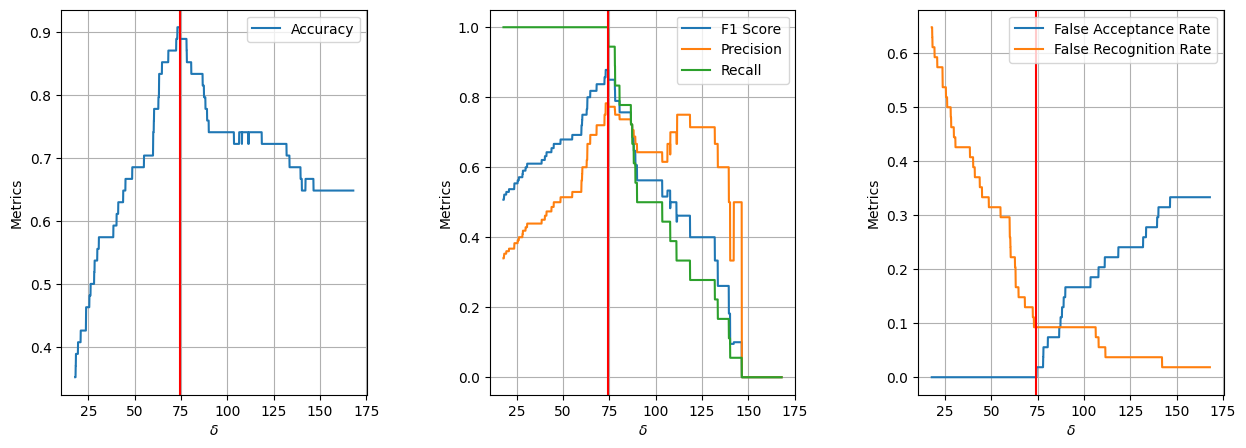

Saved plot at DELTA_acc.pdf
Saved plot at DELTA_pre_rec_and_f1.pdf
Saved plot at DELTA_far_and_frr.pdf
_______
Epsilon: 0.0
Compute predictions...
The norm threshold is not going to be used.
********* TESTING **************


Avg Accuracy: 0.8703703703703703
Avg Accuracy Train: 0.8333333333333334
Avg Recall: 0.9444444444444444


<Figure size 640x480 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

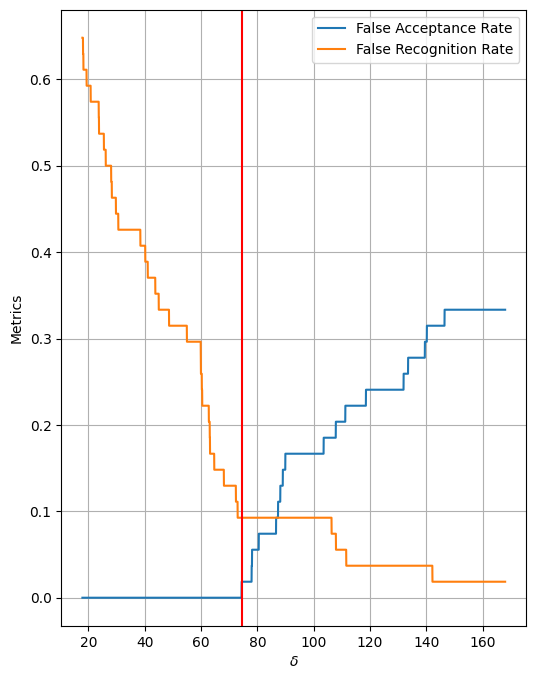

In [13]:
np.random.seed(0)
summary2 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                training_config=training_config, 
                tuning_config=tuning_config,
                reshaper=reshaper,
                epsilons=[0.0],
                xi=0,
                use_norm_threshold=False,
                num_iterations=1)


In [14]:
summary2 

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0.0,0.87037,0.833333,0.018519,0.092593,0.772727,0.944444,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### $\delta_1= tuned$;  Norm Threshold = True; Outliers = True 

********* TRAINING **************
Normalization Threshold has been chosen by the user: 0.75
********* TUNING **************
Min delta:  17.895230648638833 ; Max delta:  168.02271722272448


tuning delta1...: 100%|███████████████████| 3200/3200 [00:00<00:00, 6576.96it/s]


Chosen delta1: 74.38069747213684


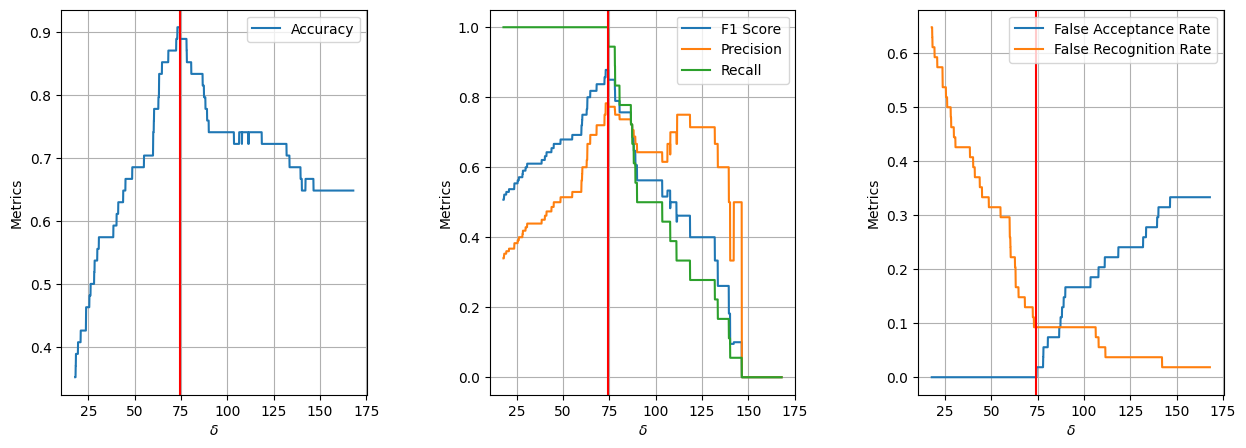

Saved plot at DELTA_acc.pdf
Saved plot at DELTA_pre_rec_and_f1.pdf
Saved plot at DELTA_far_and_frr.pdf
_______
Epsilon: 0.0
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8703703703703703
Avg Accuracy Train: 0.8333333333333334
Avg Recall: 0.9444444444444444


<Figure size 640x480 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

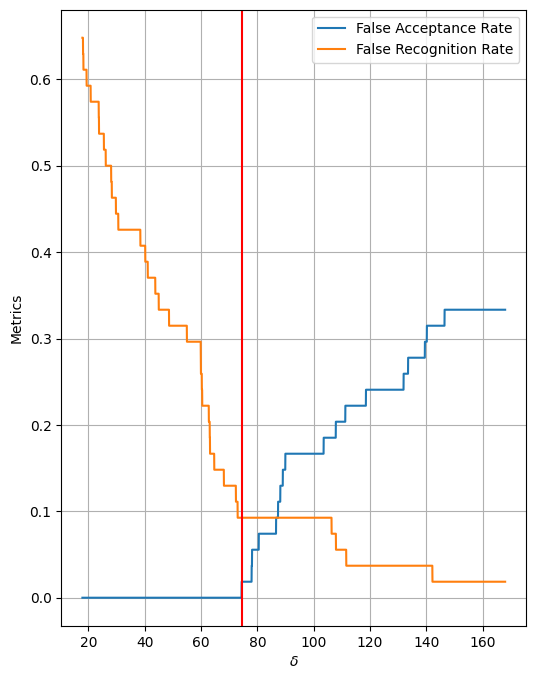

In [15]:
np.random.seed(0)

summary3 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                training_config=training_config, 
                tuning_config=tuning_config,
                reshaper=reshaper,
                epsilons=[0.0],
                xi=0,
                use_norm_threshold=True,
                num_iterations=1,
                visuals=False,
                norm_threshold=0.75,
                delta1=None)

In [16]:
summary3

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0.0,0.87037,0.833333,0.018519,0.092593,0.772727,0.944444,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Quantum Algorithm

### $\delta_1= tuned$;  Norm Threshold = True; Outliers = True


********* TRAINING **************
Normalization Threshold has been chosen by the user: 0.75
********* TUNING **************
Min delta:  17.895230648638833 ; Max delta:  168.02271722272448


tuning delta1...: 100%|███████████████████| 3200/3200 [00:00<00:00, 6536.63it/s]


Chosen delta1: 74.38069747213684


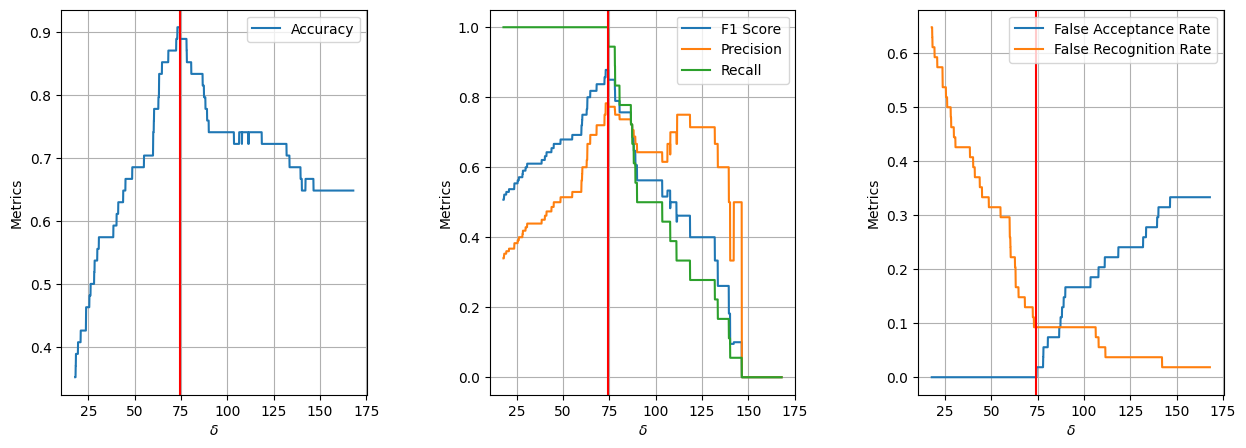

Saved plot at DELTA_acc.pdf
Saved plot at DELTA_pre_rec_and_f1.pdf
Saved plot at DELTA_far_and_frr.pdf
_______
Epsilon: 0
Computing runtimes...
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8703703703703702
Avg Accuracy Train: 0.8333333333333331
Avg Recall: 0.9444444444444444
_______
Epsilon: 5
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 5
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8609259259259257
Avg Accuracy Train: 0.8277777777777777
Avg Recall: 0.9272222222222222
_______
Epsilon: 10
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 10
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8527777777777775
Avg Accuracy Train: 0.8255555555555553
Avg Recall: 0.9072222222222222
_______
Epsilon: 15
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 15
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.848148148148148
Avg Accuracy Train: 0.8319444444444443
Avg Recall: 0.8805555555555555
_______
Epsilon: 20
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 20
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8414814814814813
Avg Accuracy Train: 0.8313888888888888
Avg Recall: 0.8616666666666666
_______
Epsilon: 25
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 25
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8359259259259259
Avg Accuracy Train: 0.8299999999999998
Avg Recall: 0.8477777777777775
_______
Epsilon: 30
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 30
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8335185185185183
Avg Accuracy Train: 0.8266666666666665
Avg Recall: 0.8472222222222221
_______
Epsilon: 35
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 35
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8201851851851849
Avg Accuracy Train: 0.8238888888888887
Avg Recall: 0.8127777777777777
_______
Epsilon: 40
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 40
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8118518518518516
Avg Accuracy Train: 0.8249999999999998
Avg Recall: 0.7855555555555557
_______
Epsilon: 45
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 45
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.7901851851851851
Avg Accuracy Train: 0.8213888888888887
Avg Recall: 0.7277777777777779
_______
Epsilon: 50
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 50
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.7725925925925925
Avg Accuracy Train: 0.8169444444444445
Avg Recall: 0.6838888888888889
_______
Epsilon: 55
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 55
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.7477777777777775
Avg Accuracy Train: 0.8213888888888888
Avg Recall: 0.6005555555555556
_______
Epsilon: 60
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 60
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.73
Avg Accuracy Train: 0.8155555555555556
Avg Recall: 0.5588888888888889
_______
Epsilon: 65
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 65
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.6996296296296297
Avg Accuracy Train: 0.816111111111111
Avg Recall: 0.4666666666666666
_______
Epsilon: 70
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 70
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.6870370370370372
Avg Accuracy Train: 0.8269444444444445
Avg Recall: 0.4072222222222222
_______
Epsilon: 75
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 75
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.666851851851852
Avg Accuracy Train: 0.8183333333333332
Avg Recall: 0.3638888888888889
_______
Epsilon: 80
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 80
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.6483333333333334
Avg Accuracy Train: 0.8202777777777776
Avg Recall: 0.3044444444444444
_______
Epsilon: 85
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 85
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.6301851851851851
Avg Accuracy Train: 0.823611111111111
Avg Recall: 0.2433333333333333
_______
Epsilon: 90
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 90
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.612962962962963
Avg Accuracy Train: 0.8222222222222222
Avg Recall: 0.19444444444444442
_______
Epsilon: 95
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 95
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.6050000000000001
Avg Accuracy Train: 0.816111111111111
Avg Recall: 0.1827777777777778
_______
Epsilon: 100
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 100
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5868518518518518
Avg Accuracy Train: 0.8152777777777779
Avg Recall: 0.12999999999999998
_______
Epsilon: 105
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 105
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5820370370370371
Avg Accuracy Train: 0.8233333333333331
Avg Recall: 0.09944444444444446
_______
Epsilon: 110
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 110
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5672222222222223
Avg Accuracy Train: 0.8136111111111112
Avg Recall: 0.07444444444444445
_______
Epsilon: 115
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 115
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5657407407407408
Avg Accuracy Train: 0.8172222222222222
Avg Recall: 0.06277777777777778
_______
Epsilon: 120
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 120
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5605555555555556
Avg Accuracy Train: 0.8130555555555555
Avg Recall: 0.055555555555555546
_______
Epsilon: 125
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 125
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5520370370370371
Avg Accuracy Train: 0.8102777777777779
Avg Recall: 0.035555555555555556
_______
Epsilon: 130
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 130
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5444444444444445
Avg Accuracy Train: 0.8022222222222222
Avg Recall: 0.028888888888888888
_______
Epsilon: 135
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 135
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5429629629629631
Avg Accuracy Train: 0.804722222222222
Avg Recall: 0.019444444444444445
_______
Epsilon: 140
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 140
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.534074074074074
Avg Accuracy Train: 0.7955555555555555
Avg Recall: 0.01111111111111111
_______
Epsilon: 145
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 145
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5279629629629629
Avg Accuracy Train: 0.7858333333333333
Avg Recall: 0.012222222222222223
_______
Epsilon: 150
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 150
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.524074074074074
Avg Accuracy Train: 0.7783333333333333
Avg Recall: 0.015555555555555553
_______
Epsilon: 155
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 155
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5181481481481482
Avg Accuracy Train: 0.775
Avg Recall: 0.0044444444444444444
_______
Epsilon: 160
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 160
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5111111111111111
Avg Accuracy Train: 0.7641666666666665
Avg Recall: 0.005
_______
Epsilon: 165
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 165
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.5018518518518519
Avg Accuracy Train: 0.749722222222222
Avg Recall: 0.006111111111111111
_______
Epsilon: 170
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 170
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.4848148148148148
Avg Accuracy Train: 0.7263888888888892
Avg Recall: 0.0016666666666666666
_______
Epsilon: 175
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 175
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.48
Avg Accuracy Train: 0.7191666666666666
Avg Recall: 0.0016666666666666666
_______
Epsilon: 180
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 180
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.4612962962962962
Avg Accuracy Train: 0.6902777777777778
Avg Recall: 0.003333333333333333
_______
Epsilon: 185
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 185
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.4629629629629629
Avg Accuracy Train: 0.6930555555555555
Avg Recall: 0.002777777777777778
_______
Epsilon: 190
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 190
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.4435185185185184
Avg Accuracy Train: 0.6644444444444444
Avg Recall: 0.0016666666666666666
_______
Epsilon: 195
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 195
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.4333333333333333
Avg Accuracy Train: 0.65
Avg Recall: 0.0
_______
Epsilon: 200
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 200
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.4166666666666666
Avg Accuracy Train: 0.6247222222222222
Avg Recall: 0.0005555555555555556
_______
Epsilon: 205
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 205
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.4142592592592592
Avg Accuracy Train: 0.6205555555555555
Avg Recall: 0.0016666666666666666
_______
Epsilon: 210
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 210
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.39574074074074067
Avg Accuracy Train: 0.5930555555555554
Avg Recall: 0.0011111111111111111
_______
Epsilon: 215
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 215
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.37833333333333335
Avg Accuracy Train: 0.5669444444444445
Avg Recall: 0.0011111111111111111
_______
Epsilon: 220
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 220
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.37092592592592594
Avg Accuracy Train: 0.5561111111111111
Avg Recall: 0.0005555555555555556
_______
Epsilon: 225
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 225
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.3598148148148148
Avg Accuracy Train: 0.5397222222222222
Avg Recall: 0.0
_______
Epsilon: 230
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 230
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.34518518518518526
Avg Accuracy Train: 0.5177777777777779
Avg Recall: 0.0
_______
Epsilon: 235
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 235
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.3368518518518519
Avg Accuracy Train: 0.5052777777777778
Avg Recall: 0.0
_______
Epsilon: 240
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 240
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.32648148148148143
Avg Accuracy Train: 0.4897222222222222
Avg Recall: 0.0
_______
Epsilon: 245
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 245
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.31407407407407406
Avg Accuracy Train: 0.47083333333333327
Avg Recall: 0.0005555555555555556
_______
Epsilon: 250
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 250
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.2944444444444445
Avg Accuracy Train: 0.4416666666666666
Avg Recall: 0.0
_______
Epsilon: 255
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 255
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.28259259259259256
Avg Accuracy Train: 0.4238888888888889
Avg Recall: 0.0
_______
Epsilon: 260
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 260
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.2698148148148148
Avg Accuracy Train: 0.4047222222222222
Avg Recall: 0.0
_______
Epsilon: 265
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 265
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.26888888888888884
Avg Accuracy Train: 0.40333333333333327
Avg Recall: 0.0
_______
Epsilon: 270
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 270
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.2535185185185185
Avg Accuracy Train: 0.3802777777777779
Avg Recall: 0.0
_______
Epsilon: 275
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 275
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.23537037037037034
Avg Accuracy Train: 0.3530555555555555
Avg Recall: 0.0
_______
Epsilon: 280
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 280
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.23037037037037034
Avg Accuracy Train: 0.3455555555555555
Avg Recall: 0.0
_______
Epsilon: 285
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 285
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.2168518518518519
Avg Accuracy Train: 0.3252777777777778
Avg Recall: 0.0
_______
Epsilon: 290
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 290
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.2044444444444444
Avg Accuracy Train: 0.3066666666666667
Avg Recall: 0.0
_______
Epsilon: 295
Computing runtimes...


sqrt p: 16.97056274847714
mu: 8.343215095468386
max_c_train_norm: 21.119071952988083
avg U_bar_norms: 15.670539020110414
epsilon: 295
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.20574074074074075
Avg Accuracy Train: 0.30861111111111117
Avg Recall: 0.0


<Figure size 640x480 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

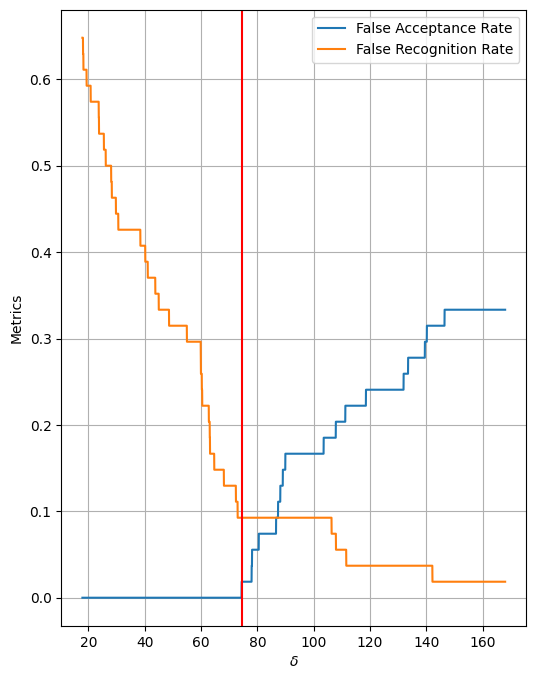

In [17]:
np.random.seed(0)

epsilons_domain = range(0, 300, 5)
summary4, rts4 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                               training_config=training_config, 
                               tuning_config=tuning_config,
                               reshaper=reshaper,
                               epsilons=epsilons_domain,
                               use_norm_threshold=True,
                               norm_threshold=0.75,
                               num_iterations=100,
                               compute_runtimes=True)


In [18]:
summary4

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.870370,0.833333,0.018519,0.092593,0.772727,0.944444,0.850000,1.110223e-16,2.220446e-16,3.469447e-18,2.775558e-17,3.330669e-16,0.000000,4.440892e-16
1,5,0.860926,0.827778,0.024259,0.097037,0.761216,0.927222,0.835903,1.126285e-02,1.111111e-02,8.564690e-03,7.908947e-03,1.576447e-02,0.025694,1.679392e-02
2,10,0.852778,0.825556,0.030926,0.099815,0.752663,0.907222,0.822366,1.840241e-02,2.044263e-02,1.081551e-02,1.524716e-02,2.995021e-02,0.032447,2.591081e-02
3,15,0.848148,0.831944,0.039815,0.096667,0.752774,0.880556,0.811154,2.028602e-02,1.858207e-02,1.490137e-02,1.375366e-02,2.802577e-02,0.044704,2.947789e-02
4,20,0.841481,0.831389,0.046111,0.098148,0.745658,0.861667,0.798941,2.404842e-02,2.231059e-02,1.666564e-02,1.373370e-02,3.009050e-02,0.049997,3.383341e-02
5,25,0.835926,0.830000,0.050741,0.098519,0.742269,0.847778,0.790846,2.512247e-02,2.554348e-02,1.689555e-02,1.632993e-02,3.506183e-02,0.050687,3.532749e-02
6,30,0.833519,0.826667,0.050926,0.100370,0.738531,0.847222,0.788471,2.752913e-02,2.836055e-02,1.724809e-02,1.660069e-02,3.530892e-02,0.051744,3.624389e-02
7,35,0.820185,0.823889,0.062407,0.100556,0.730386,0.812778,0.768357,2.896180e-02,2.919179e-02,2.022761e-02,1.929040e-02,4.042927e-02,0.060683,4.167225e-02
8,40,0.811852,0.825000,0.071481,0.098889,0.726130,0.785556,0.753284,2.971285e-02,2.952818e-02,2.498559e-02,1.681416e-02,3.775236e-02,0.074957,4.835095e-02
9,45,0.790185,0.821389,0.090741,0.103519,0.700668,0.727778,0.712548,3.384940e-02,2.700451e-02,2.727948e-02,1.778067e-02,4.532974e-02,0.081838,5.745359e-02


Saved plot at ORL_epsilon_wrt_acc_train_and_recall.pdf


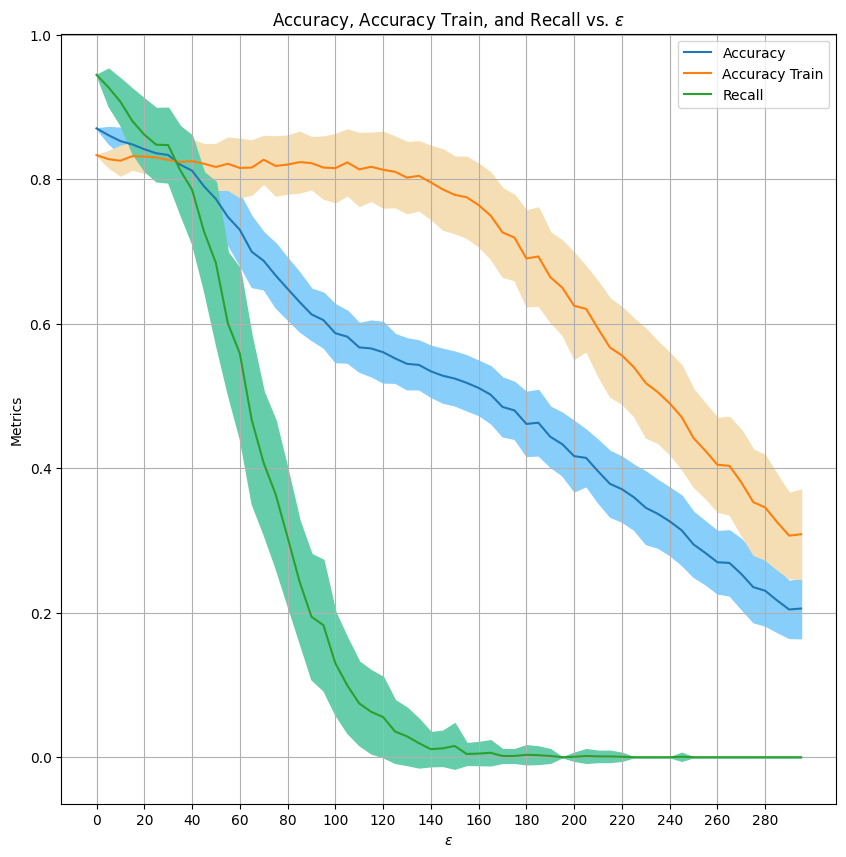

Saved plot at ORL_epsilon_wrt_acc_train_and_recall.pdf


<Figure size 640x480 with 0 Axes>

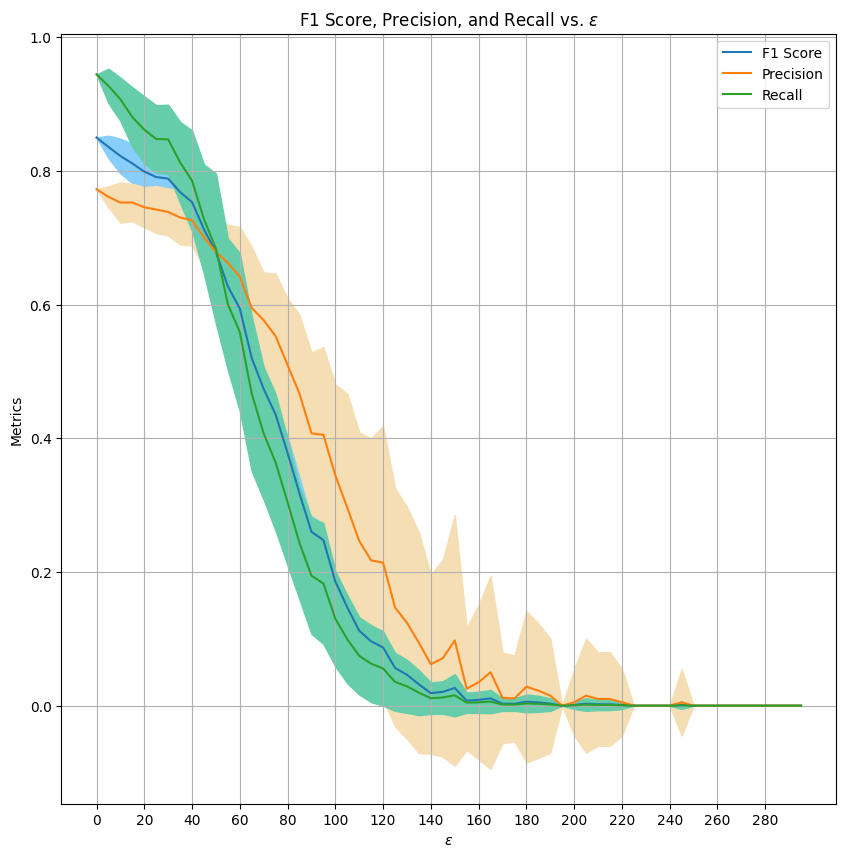

In [19]:
plot_metrics_at_varying_epsilon(summary4, "ORL", epsilons_domain, tick_step=4)

In [20]:
from quantum_eigenfaces.utils.runtime import find_highest_acceptable_epsilon

highest_acceptable_epsilon = find_highest_acceptable_epsilon(summary4)
highest_acceptable_epsilon

0.8703703703703702
0.848611111111111


10

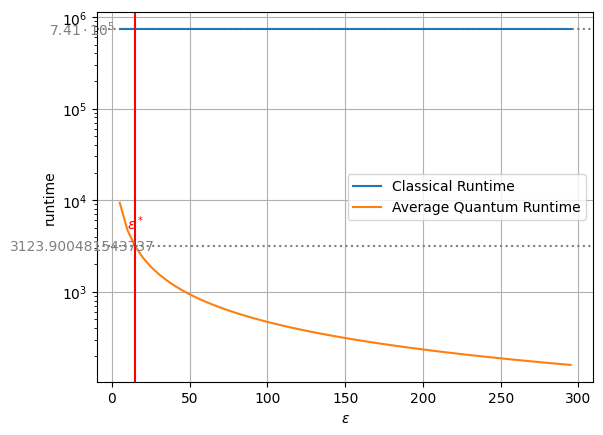

In [22]:
import matplotlib.pyplot as plt
def plot_quantum_vs_classical(rts, highest_acceptable_epsilon):
    
    # Classical runtime
    crt = rts["classical runtime"].values[0]
    plt.axhline(crt, linestyle=":", c="grey")
    plt.text(-19, crt, "$7.41 \cdot 10^5$", ha='center', va='center', c="grey")
    plt.plot(rts["epsilon"], rts["classical runtime"], label="Classical Runtime")
    
    # Quantum runtime
    plt.plot(rts["epsilon"], rts["average runtime"], label="Average Quantum Runtime")
    plt.xlabel("$\epsilon$")
    plt.ylabel("runtime")
    
    
    plt.yscale('log')
    
    plt.axvline(x=highest_acceptable_epsilon, c="red")
    
    plt.text(highest_acceptable_epsilon, 5600, r'$\epsilon^*$', ha='center', va='center', c="red")
    
    y = rts[rts["epsilon"] == highest_acceptable_epsilon]["average runtime"].values[0]
    plt.axhline(y, linestyle=":", c="grey")
    #plt.text(-19, y, "$1.34 \cdot 10^4$", ha='center', va='center', c="grey")
    plt.text(-19, y, str(y), ha='center', va='center', c="grey")

    plt.grid(True)
    plt.legend()
    plt.savefig("ORL_runtime.pdf")
    
plot_quantum_vs_classical(rts4[1:], highest_acceptable_epsilon=15)